In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

#from torch.utils.tensorboard import SummaryWriter

import sklearn
import functools
import operator

import sys

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

import dataset_class_gsimage
import vaenc_torch_net_class
#import aenc_utils
import utils

from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")
    
cpu_device = torch.device("cpu")

Utilizing CUDA


In [3]:
"""Download dataset provided by pytorch"""

from torchvision import datasets, transforms
# MNIST Dataset
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.])])

transform = torchvision.transforms.Compose([
                #dataset_class_gsimage.send_to_device(target_device=cpu_device),
                #dataset_class_gsimage.numpy(typ=np.uint8),
                #dataset_class_gsimage.torch_tensor(typ=torch.uint8),
                #dataset_class_gsimage.roll_channel_axis(old_pos=0, new_pos=-1, device=torch.device("cpu")),
                #torchvision.transforms.ToPILImage(mode=None),
                torchvision.transforms.RandomResizedCrop(size=(28,28),scale=(0.8, 1.0), ratio=(0.75, 1.33333), interpolation=2),
                torchvision.transforms.RandomRotation((-30,+30), resample=False, expand=False, center=None),
                torchvision.transforms.ToTensor(),
                dataset_class_gsimage.send_to_device(target_device=device),
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
                torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                #torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

0it [00:00, ?it/s]

9920512it [00:01, 6776419.74it/s]                             


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 65582.66it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


1654784it [00:00, 1881843.81it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


8192it [00:00, 35442.80it/s]            


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


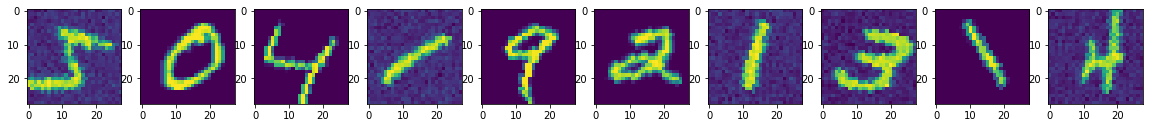

In [4]:
plt.rcParams['figure.figsize'] = [20, 5]
n_load = 10
i = 0

fig, ax = plt.subplots(1,n_load)
for i in range(n_load):
    ax[i].imshow(train_dataset[i][0].detach().cpu().numpy().reshape([28,28]))
#plt.show()
#print(dataset.get_image(i)[1])

In [5]:
"""...But we will be using our custom dataset and functions!"""

#mnist_image_folder = "../data/mnist/"
#folder of the dataset
mnist_image_folder = "/media/data/sbulusu/datasets/mnist/mnist_images/"
mnist_image_names = os.listdir(mnist_image_folder)
#relative paths of all images to mnist_image_folder
mnist_image_paths = glob.glob("mnist/*")
image_size = [1,28,28]
#label_path_csv = "../data/mnist_labels.csv"
label_path_csv = "/media/data/sbulusu/datasets/mnist/mnist_labels.csv"
dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv, transform="default", device=device)
#dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv, transform=None, device=device)
#name of the attribute in the csv file
target_attributes = ["number"]
dataset.set_label_names(target_attributes)

['number']

In [6]:

dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.send_to_device(target_device=cpu_device),
                #dataset_class_gsimage.numpy(typ=np.uint8),
                dataset_class_gsimage.torch_tensor(typ=torch.uint8),
                #dataset_class_gsimage.roll_channel_axis(old_pos=0, new_pos=-1, device=torch.device("cpu")),
                torchvision.transforms.ToPILImage(mode=None),
                torchvision.transforms.RandomResizedCrop(size=(28,28),scale=(0.8, 1.0), ratio=(0.75, 1.33333), interpolation=2),
                torchvision.transforms.RandomRotation((-30,+30), resample=False, expand=False, center=None),
                torchvision.transforms.ToTensor(),
                dataset_class_gsimage.send_to_device(target_device=device),
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
                torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])


/home/sbulusu/qcd_ml/neural_networks/libs/dataset_class_gsimage.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor.clone(), dtype=self.typ)


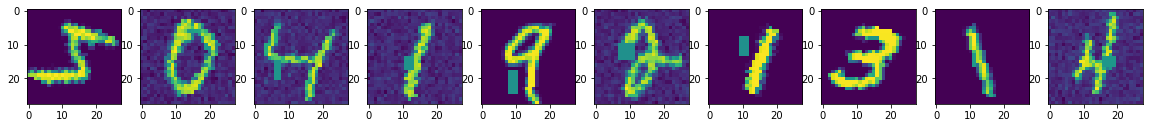

In [7]:

plt.rcParams['figure.figsize'] = [20, 5]
n_load = 10
i = 0

fig, ax = plt.subplots(1,n_load)
for i in range(n_load):
    ax[i].imshow(dataset.get_image(i)[0].detach().cpu().numpy().reshape([28,28]))
#plt.show()
#print(dataset.get_image(i)[1])


In [8]:

dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.], std=[1.0]),
                #torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                #torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])


In [9]:


"""Manually set network structure"""
"""
    This list can be loaded into the constructor of the Net neural network class, to automatically generate the network structure
    type = pointer to the layer function'
    layer_pars = parameters which must be given to the layer function in order to initialize it
    act_func = activation function to be applied directly after feeding to the corresponding layer
    dropout = certain neurons cna be dropped out if specified
"""

input_size = dataset.get_input_size()
output_size = input_size

latent_size = 20

fc_input_size = np.product(input_size)
print(fc_input_size)

784


In [10]:

act_func = torch.relu
#act_func = F.leaky_relu
#act_func = torch.sigmoid
encoder_struct = []

"""
encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
encoder_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.2 }} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": 800}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 800, "out_features": 400}, "bias": True} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 400, "out_features": latent_size}, "bias": True} )
"""

encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
#encoder_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.2 }} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size//2}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//2, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size//8}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//8, "out_features": latent_size}, "bias": True, "act_func": act_func} )


"""
act_func = torch.relu
#act_func = torch.sigmoid

encoder_struct = []
kernel_pars = [ [[1,2],[3,3],1,0], [[2,2],[2,2],2,0], [[2,4],[2,2],1,0], [[4,4],[2,2],2,0], [[4,4],[4,4],2,0]]
act_func = torch.relu

for i, kernel_par in enumerate(kernel_pars):
    if i%2 == 0:
        layer_type = nn.Conv2d
        encoder_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3], "bias": True}, "act_func": act_func} )
    else:
        layer_type = nn.MaxPool2d
        encoder_struct.append( {"type": layer_type, "layer_pars": {"kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3]}} )
        
encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
"""

encoder_sizes = utils.calc_layer_sizes(input_size, encoder_struct)
print(encoder_sizes)

latent_size = encoder_sizes[-1]
input_size = encoder_sizes[0]

0
<class 'torch.nn.modules.flatten.Flatten'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'torch.nn.modules.linear.Linear'>
[[1, 28, 28], 784, 392, 196, 98, 20]


In [11]:
act_func = torch.relu
#act_func = F.leaky_relu
#act_func = torch.sigmoid
decoder_struct = []

"""
decoder_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.2 }} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": latent_size//2, "out_features": 400}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 400, "out_features": 800}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": 800, "out_features": fc_input_size}, "bias": True, "act_func": torch.sigmoid} )
decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": input_size}} )
"""

#decoder_struct.append( {"type": nn.Dropout, "layer_pars": {"p": 0.2 }} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": latent_size//2, "out_features": fc_input_size//16}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//16, "out_features": fc_input_size//8}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//8, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size}, "bias": True, "act_func": torch.sigmoid} )
decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": input_size}} )


"""
decoder_struct = []

decoder_input_shape = encoder_sizes[-2]
#input channel size for deconvolution
decoder_input_shape[0] = decoder_input_shape[0]//2

dc = decoder_input_shape[0]
#reverse above kernel_pars = [ [[dc,dc],[2,2],2,1], [[dc,dc],[2,2],2,1], [[dc,dc],[3,3],2,2], [[dc,dc],[3,3],2,2], [[dc,1],[4,4],2,2]]
kernel_pars = kernel_pars[::-1]
for kernel_par in kernel_pars:
    kernel_par[0][0] = dc
    kernel_par[0][1] = dc
act_func = torch.relu

decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": decoder_input_shape}} )

for i, kernel_par in enumerate(kernel_pars):
    #if i%2 == 0:
    layer_type = nn.ConvTranspose2d
    decoder_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3], "bias": True}, "act_func": act_func} )
    
        
#output channel size      
decoder_struct[-1]["layer_pars"]["out_channels"] = 1
"""

decoder_sizes = utils.calc_layer_sizes(latent_size//2, decoder_struct)

print(decoder_sizes)

0
<class 'torch.nn.modules.linear.Linear'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'utils.Reshape'>
[10, 49, 98, 196, 784, [1, 28, 28]]


In [12]:
"""
HYPERPARAMETERS
"""

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

#val_epochs = [10,20,30,40,50,60,70]
#val_epochs = list(range(0,50))
val_epochs = list(range(0,100))
#val_epochs = [10,15,20,25,30,35,40,45]
#val_epochs = [0,1,2,3,4,5,6,7,8,9,10,15,20]
#val_epochs = [0,1]

#save states of the network for particular epochs, sate can be reloaded afterwards!
save_state_epochs = [10000]


"""create list of parameters manually"""

hyper_parameters = {}
loss_func_kwargs = {"reduction": "sum"}
#hyper_parameters["loss_func"] = nn.CrossEntropyLoss
#hyper_parameters["loss_func"] = nn.BCELoss
hyper_parameters["loss_func"] = nn.MSELoss
hyper_parameters["optimizer"] = optim.Adam
hyper_parameters["batch_size"] = 20
hyper_parameters["lr"] = 0.00001

hyper_parameters["gamma"] = 0.01

hyper_parameters["val_method"] = "holdout"
hyper_parameters["val_method_pars"] = {"train" : 0.9, "val" : 0.1, "test" : 0.}
#hyper_parameters["val_method"] = "k_fold"
#hyper_parameters["val_method_pars"] = 5

In [13]:
epochs = max(val_epochs)+1

lr=hyper_parameters["lr"]
gamma = hyper_parameters["gamma"]
batch_size = hyper_parameters["batch_size"]
loss_func = hyper_parameters["loss_func"](**loss_func_kwargs)
#loss_func = hyper_parameters["loss_func"]()
val_method = hyper_parameters["val_method"]
val_method_pars = hyper_parameters["val_method_pars"]
optimizer_type = hyper_parameters["optimizer"]

val_pred_paths = []
val_label_paths = []

train_loss = np.zeros(epochs)
val_loss = np.zeros(len(val_epochs))

net_state_paths = []

#create training log
log_file_name = "log.txt"
log_file = open(log_file_name, "w")

In [14]:
"""Generate network class instance"""
net = vaenc_torch_net_class.AutoEncoder(encoder_struct=encoder_struct, decoder_struct=decoder_struct, input_size=input_size, latent_size=latent_size, device=device)
net.set_batch_size(batch_size)
net.to(device)
net_parameters = net.parameters()

optimizer = optimizer_type(net_parameters, lr=lr)

0
<class 'torch.nn.modules.flatten.Flatten'>
1
<class 'torch.nn.modules.linear.Linear'>
2
<class 'torch.nn.modules.linear.Linear'>
3
<class 'torch.nn.modules.linear.Linear'>
4
<class 'torch.nn.modules.linear.Linear'>
Initializing Encoder:

Adding {'type': <class 'torch.nn.modules.flatten.Flatten'>, 'layer_pars': {'start_dim': 1}}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 784, 'out_features': 392}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7fdc4efd8be0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 392, 'out_features': 196}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7fdc4efd8be0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 196, 'out_features': 98}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7fdc4efd8be0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars':

In [15]:
"""Load and split data"""

split_indices = utils.load_split_indices(dataset=dataset, batch_size=batch_size, method=val_method, method_pars=val_method_pars, shuffle=True, random_seed=random_seed, log_file=log_file)

train_indices = split_indices[0][0]
val_indices = split_indices[0][1]
test_indices = split_indices[0][2]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)


size of val set :1112

size of train set :8888




mean epoch 0 train loss: 3184.749815111482



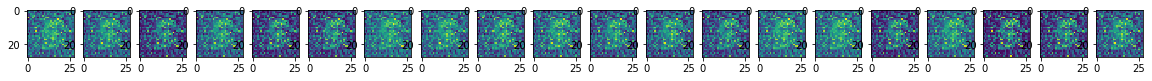


mean epoch 0 val loss: 2035.340785435268

Saving validation results for epoch 0
validation prediction: val/val_epoch_0_pred
validation label: val/val_epoch_0_labels



mean epoch 1 train loss: 1473.1898016426



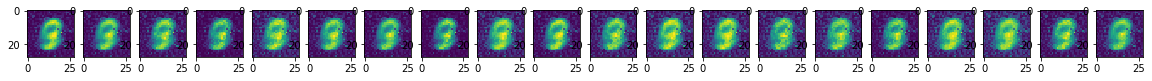


mean epoch 1 val loss: 1251.039691380092

Saving validation results for epoch 1
validation prediction: val/val_epoch_1_pred
validation label: val/val_epoch_1_labels



mean epoch 2 train loss: 1207.8752435919944



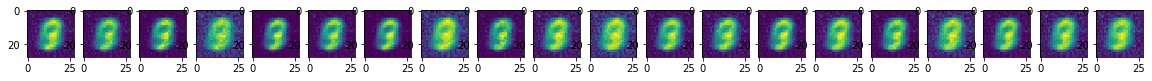


mean epoch 2 val loss: 1161.1836013793945

Saving validation results for epoch 2
validation prediction: val/val_epoch_2_pred
validation label: val/val_epoch_2_labels



mean epoch 3 train loss: 1147.7018302317415



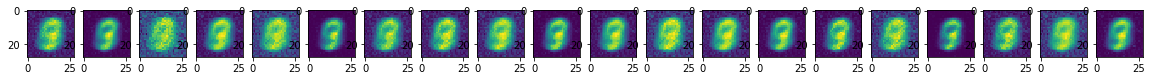


mean epoch 3 val loss: 1122.3449074881416

Saving validation results for epoch 3
validation prediction: val/val_epoch_3_pred
validation label: val/val_epoch_3_labels



mean epoch 4 train loss: 1115.3737585174904



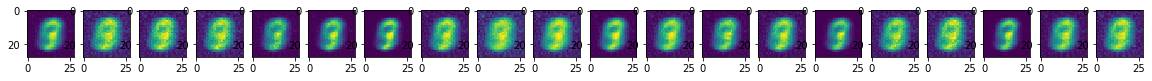


mean epoch 4 val loss: 1094.2180873325892

Saving validation results for epoch 4
validation prediction: val/val_epoch_4_pred
validation label: val/val_epoch_4_labels



mean epoch 5 train loss: 1091.4529113769531



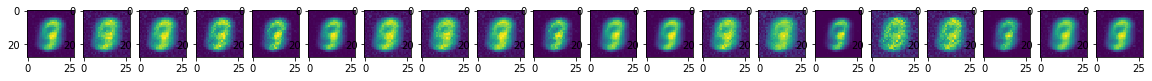


mean epoch 5 val loss: 1071.9572971888952

Saving validation results for epoch 5
validation prediction: val/val_epoch_5_pred
validation label: val/val_epoch_5_labels



mean epoch 6 train loss: 1071.862810044878



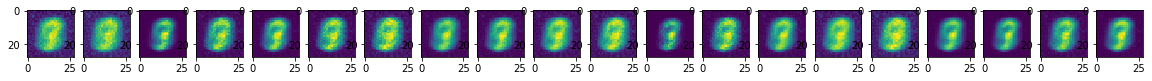


mean epoch 6 val loss: 1052.2464490618024

Saving validation results for epoch 6
validation prediction: val/val_epoch_6_pred
validation label: val/val_epoch_6_labels



mean epoch 7 train loss: 1053.194672522384



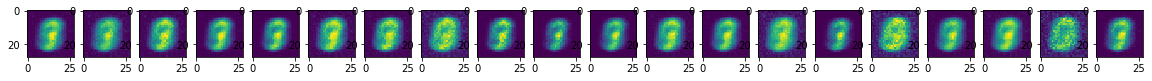


mean epoch 7 val loss: 1033.0912791660853

Saving validation results for epoch 7
validation prediction: val/val_epoch_7_pred
validation label: val/val_epoch_7_labels



mean epoch 8 train loss: 1033.702117851343



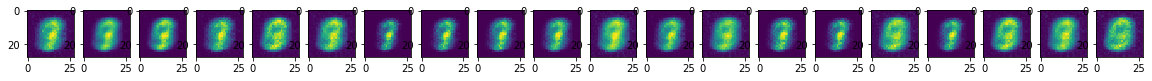


mean epoch 8 val loss: 1014.3040727887835

Saving validation results for epoch 8
validation prediction: val/val_epoch_8_pred
validation label: val/val_epoch_8_labels



mean epoch 9 train loss: 1012.9448538448033



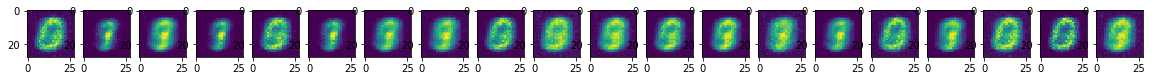


mean epoch 9 val loss: 993.4673483712332

Saving validation results for epoch 9
validation prediction: val/val_epoch_9_pred
validation label: val/val_epoch_9_labels



mean epoch 10 train loss: 993.9938877062851



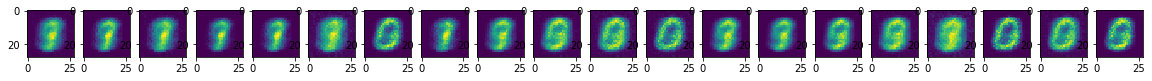


mean epoch 10 val loss: 974.2948041643415

Saving validation results for epoch 10
validation prediction: val/val_epoch_10_pred
validation label: val/val_epoch_10_labels



mean epoch 11 train loss: 977.1121730847306



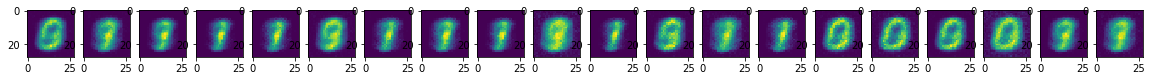


mean epoch 11 val loss: 961.0838165283203

Saving validation results for epoch 11
validation prediction: val/val_epoch_11_pred
validation label: val/val_epoch_11_labels



mean epoch 12 train loss: 961.8367589371927



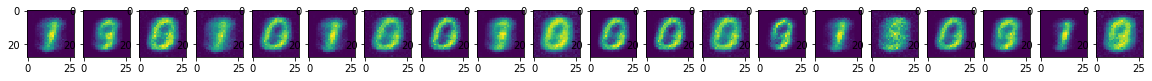


mean epoch 12 val loss: 945.4305932181222

Saving validation results for epoch 12
validation prediction: val/val_epoch_12_pred
validation label: val/val_epoch_12_labels



mean epoch 13 train loss: 945.9693161867978



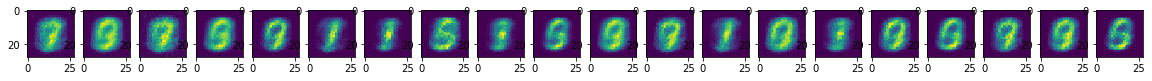


mean epoch 13 val loss: 927.824456351144

Saving validation results for epoch 13
validation prediction: val/val_epoch_13_pred
validation label: val/val_epoch_13_labels



mean epoch 14 train loss: 927.9153211957953



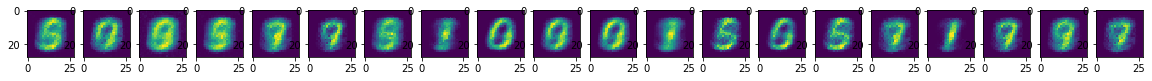


mean epoch 14 val loss: 909.4909940447126

Saving validation results for epoch 14
validation prediction: val/val_epoch_14_pred
validation label: val/val_epoch_14_labels



mean epoch 15 train loss: 911.7990796721383



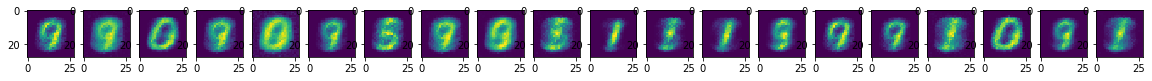


mean epoch 15 val loss: 895.8334099905832

Saving validation results for epoch 15
validation prediction: val/val_epoch_15_pred
validation label: val/val_epoch_15_labels



mean epoch 16 train loss: 898.4501093832295



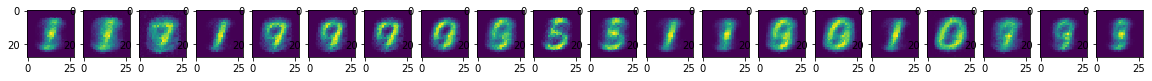


mean epoch 16 val loss: 881.413222176688

Saving validation results for epoch 16
validation prediction: val/val_epoch_16_pred
validation label: val/val_epoch_16_labels



mean epoch 17 train loss: 885.7078734665774



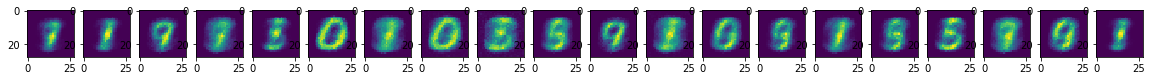


mean epoch 17 val loss: 870.310194832938

Saving validation results for epoch 17
validation prediction: val/val_epoch_17_pred
validation label: val/val_epoch_17_labels



mean epoch 18 train loss: 874.2072022170163



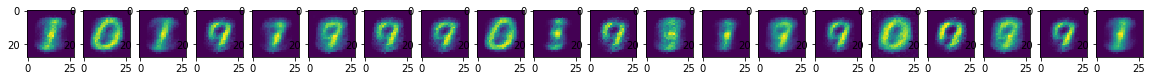


mean epoch 18 val loss: 857.5478657313755

Saving validation results for epoch 18
validation prediction: val/val_epoch_18_pred
validation label: val/val_epoch_18_labels



mean epoch 19 train loss: 861.8670189332427



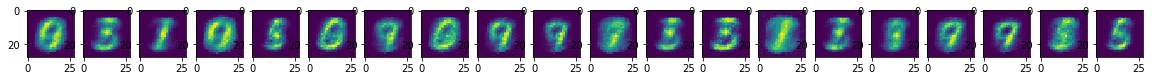


mean epoch 19 val loss: 846.8629063197544

Saving validation results for epoch 19
validation prediction: val/val_epoch_19_pred
validation label: val/val_epoch_19_labels



mean epoch 20 train loss: 849.1913208693601



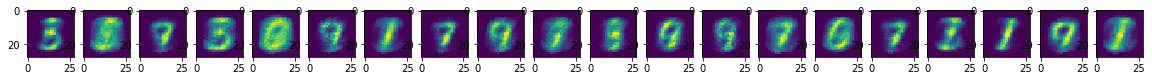


mean epoch 20 val loss: 833.791937146868

Saving validation results for epoch 20
validation prediction: val/val_epoch_20_pred
validation label: val/val_epoch_20_labels



mean epoch 21 train loss: 837.4635173669022



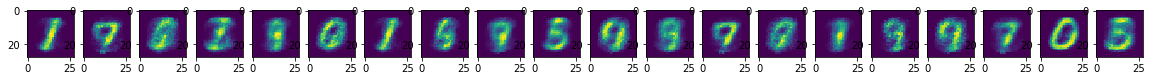


mean epoch 21 val loss: 820.5274124145508

Saving validation results for epoch 21
validation prediction: val/val_epoch_21_pred
validation label: val/val_epoch_21_labels



mean epoch 22 train loss: 826.9074933341379



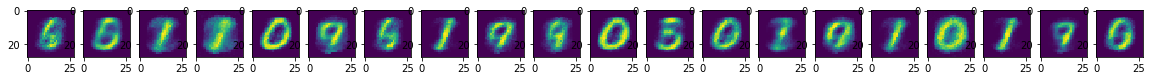


mean epoch 22 val loss: 810.2847715105329

Saving validation results for epoch 22
validation prediction: val/val_epoch_22_pred
validation label: val/val_epoch_22_labels



mean epoch 23 train loss: 818.017066801264



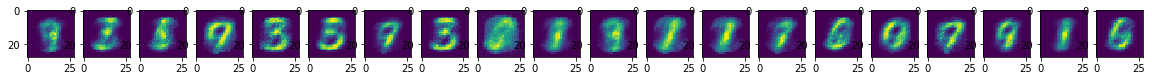


mean epoch 23 val loss: 803.0307786124093

Saving validation results for epoch 23
validation prediction: val/val_epoch_23_pred
validation label: val/val_epoch_23_labels



mean epoch 24 train loss: 809.6749851183945



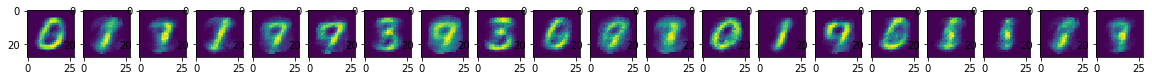


mean epoch 24 val loss: 794.9777804783413

Saving validation results for epoch 24
validation prediction: val/val_epoch_24_pred
validation label: val/val_epoch_24_labels



mean epoch 25 train loss: 802.3320067673586



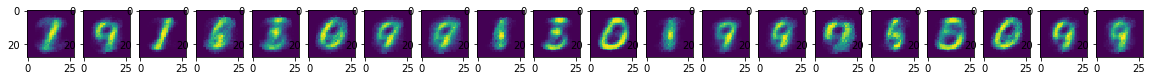


mean epoch 25 val loss: 787.5724432809012

Saving validation results for epoch 25
validation prediction: val/val_epoch_25_pred
validation label: val/val_epoch_25_labels



mean epoch 26 train loss: 795.9539366304205



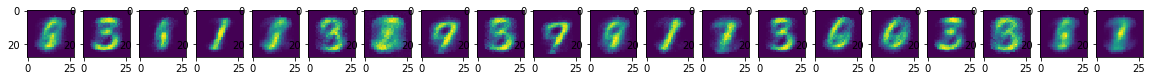


mean epoch 26 val loss: 779.8070062909808

Saving validation results for epoch 26
validation prediction: val/val_epoch_26_pred
validation label: val/val_epoch_26_labels



mean epoch 27 train loss: 789.777909045273



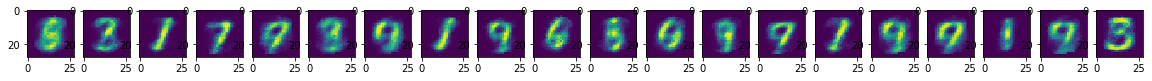


mean epoch 27 val loss: 774.1113630022321

Saving validation results for epoch 27
validation prediction: val/val_epoch_27_pred
validation label: val/val_epoch_27_labels



mean epoch 28 train loss: 784.3987691472086



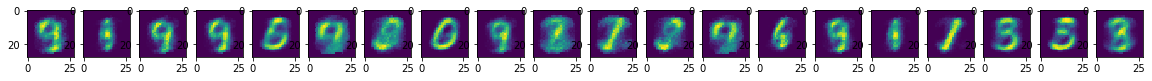


mean epoch 28 val loss: 770.611937386649

Saving validation results for epoch 28
validation prediction: val/val_epoch_28_pred
validation label: val/val_epoch_28_labels



mean epoch 29 train loss: 779.3770929572288



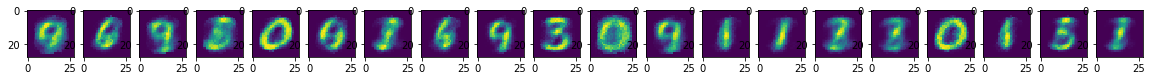


mean epoch 29 val loss: 764.5323181152344

Saving validation results for epoch 29
validation prediction: val/val_epoch_29_pred
validation label: val/val_epoch_29_labels



mean epoch 30 train loss: 773.930703358168



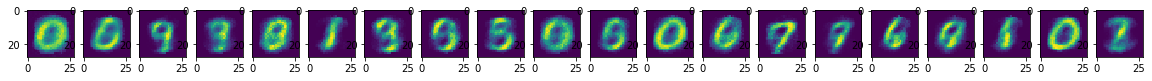


mean epoch 30 val loss: 759.4149872916086

Saving validation results for epoch 30
validation prediction: val/val_epoch_30_pred
validation label: val/val_epoch_30_labels



mean epoch 31 train loss: 768.4002187664589



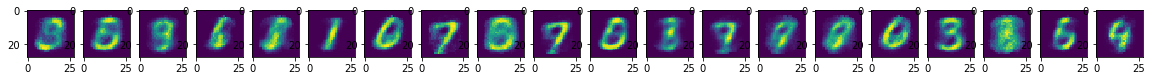


mean epoch 31 val loss: 755.0048408508301

Saving validation results for epoch 31
validation prediction: val/val_epoch_31_pred
validation label: val/val_epoch_31_labels



mean epoch 32 train loss: 764.498327911034



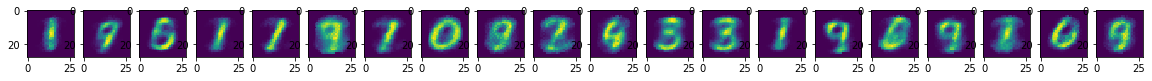


mean epoch 32 val loss: 748.5953483581543

Saving validation results for epoch 32
validation prediction: val/val_epoch_32_pred
validation label: val/val_epoch_32_labels



mean epoch 33 train loss: 759.5853949728977



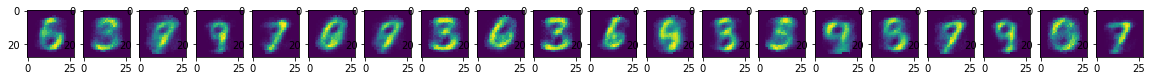


mean epoch 33 val loss: 745.8448279244559

Saving validation results for epoch 33
validation prediction: val/val_epoch_33_pred
validation label: val/val_epoch_33_labels



mean epoch 34 train loss: 754.3872675177756



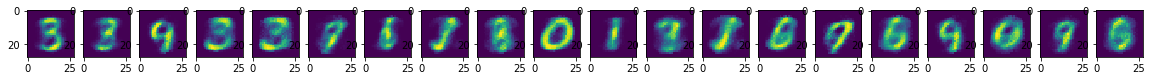


mean epoch 34 val loss: 740.8288056509836

Saving validation results for epoch 34
validation prediction: val/val_epoch_34_pred
validation label: val/val_epoch_34_labels



mean epoch 35 train loss: 748.0177253637421



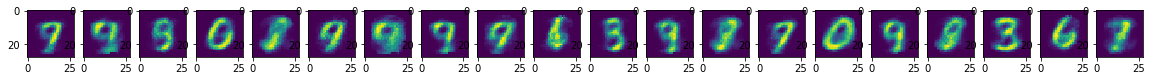


mean epoch 35 val loss: 734.4274929591587

Saving validation results for epoch 35
validation prediction: val/val_epoch_35_pred
validation label: val/val_epoch_35_labels



mean epoch 36 train loss: 743.0182380590546



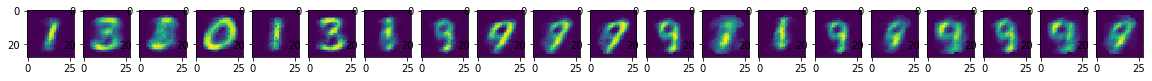


mean epoch 36 val loss: 728.7829110281808

Saving validation results for epoch 36
validation prediction: val/val_epoch_36_pred
validation label: val/val_epoch_36_labels



mean epoch 37 train loss: 737.6852788689431



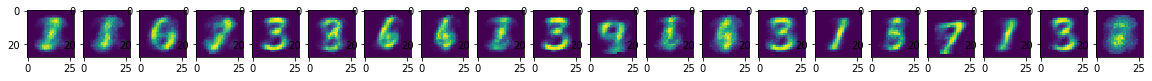


mean epoch 37 val loss: 722.3859421866281

Saving validation results for epoch 37
validation prediction: val/val_epoch_37_pred
validation label: val/val_epoch_37_labels



mean epoch 38 train loss: 732.2945530580671



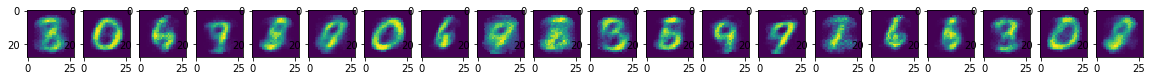


mean epoch 38 val loss: 718.5431834629604

Saving validation results for epoch 38
validation prediction: val/val_epoch_38_pred
validation label: val/val_epoch_38_labels



mean epoch 39 train loss: 726.4351453459665



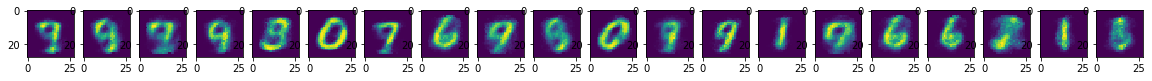


mean epoch 39 val loss: 712.6382925851004

Saving validation results for epoch 39
validation prediction: val/val_epoch_39_pred
validation label: val/val_epoch_39_labels



mean epoch 40 train loss: 721.1735732174991



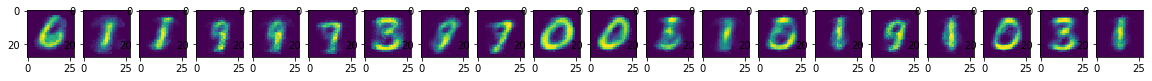


mean epoch 40 val loss: 707.528861454555

Saving validation results for epoch 40
validation prediction: val/val_epoch_40_pred
validation label: val/val_epoch_40_labels



mean epoch 41 train loss: 716.3892137163141



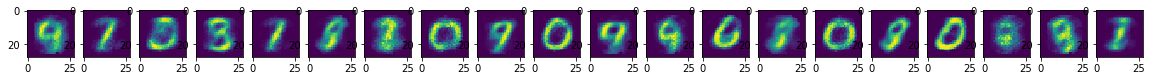


mean epoch 41 val loss: 703.9614154270718

Saving validation results for epoch 41
validation prediction: val/val_epoch_41_pred
validation label: val/val_epoch_41_labels



mean epoch 42 train loss: 711.6115693853143



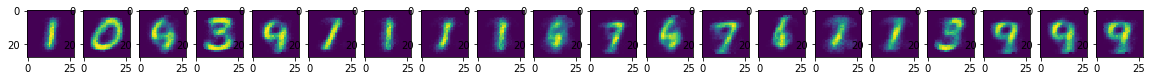


mean epoch 42 val loss: 697.4363414219448

Saving validation results for epoch 42
validation prediction: val/val_epoch_42_pred
validation label: val/val_epoch_42_labels



mean epoch 43 train loss: 707.0309590886148



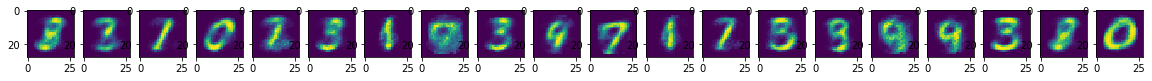


mean epoch 43 val loss: 696.1879299708775

Saving validation results for epoch 43
validation prediction: val/val_epoch_43_pred
validation label: val/val_epoch_43_labels



mean epoch 44 train loss: 702.4441784805126



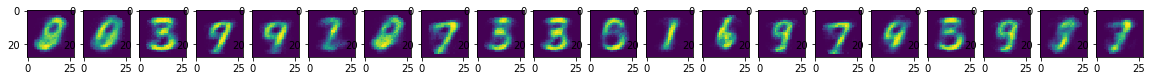


mean epoch 44 val loss: 689.3204231262207

Saving validation results for epoch 44
validation prediction: val/val_epoch_44_pred
validation label: val/val_epoch_44_labels



mean epoch 45 train loss: 698.7909865475773



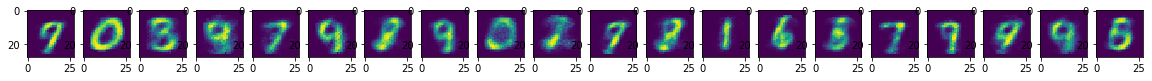


mean epoch 45 val loss: 686.1599486214774

Saving validation results for epoch 45
validation prediction: val/val_epoch_45_pred
validation label: val/val_epoch_45_labels



mean epoch 46 train loss: 695.0324774581395



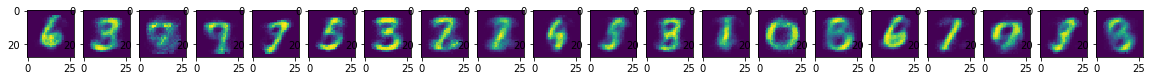


mean epoch 46 val loss: 683.0057242257254

Saving validation results for epoch 46
validation prediction: val/val_epoch_46_pred
validation label: val/val_epoch_46_labels



mean epoch 47 train loss: 692.1108106291696



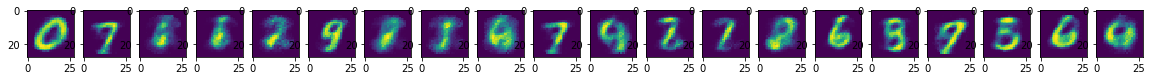


mean epoch 47 val loss: 679.2331701006208

Saving validation results for epoch 47
validation prediction: val/val_epoch_47_pred
validation label: val/val_epoch_47_labels



mean epoch 48 train loss: 689.5257708260183



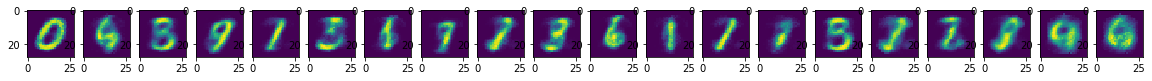


mean epoch 48 val loss: 677.8059757777622

Saving validation results for epoch 48
validation prediction: val/val_epoch_48_pred
validation label: val/val_epoch_48_labels



mean epoch 49 train loss: 685.1572059888518



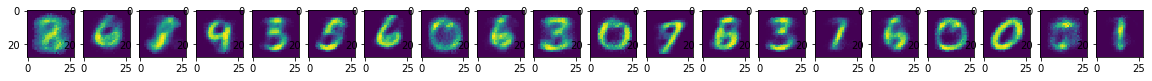


mean epoch 49 val loss: 673.6982574462891

Saving validation results for epoch 49
validation prediction: val/val_epoch_49_pred
validation label: val/val_epoch_49_labels



mean epoch 50 train loss: 682.5369354248047



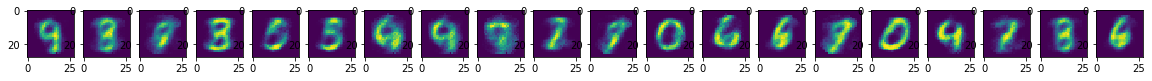


mean epoch 50 val loss: 672.048218863351

Saving validation results for epoch 50
validation prediction: val/val_epoch_50_pred
validation label: val/val_epoch_50_labels



mean epoch 51 train loss: 679.8079994458831



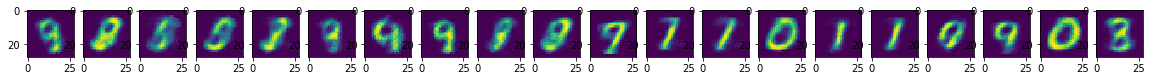


mean epoch 51 val loss: 667.2130323137555

Saving validation results for epoch 51
validation prediction: val/val_epoch_51_pred
validation label: val/val_epoch_51_labels



mean epoch 52 train loss: 677.6090264823999



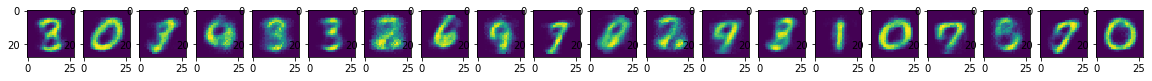


mean epoch 52 val loss: 667.351509639195

Saving validation results for epoch 52
validation prediction: val/val_epoch_52_pred
validation label: val/val_epoch_52_labels



mean epoch 53 train loss: 675.6948506901773



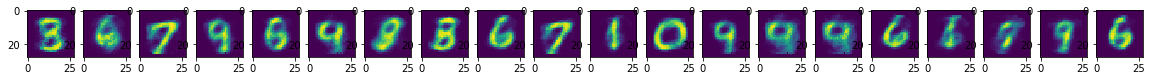


mean epoch 53 val loss: 664.112060546875

Saving validation results for epoch 53
validation prediction: val/val_epoch_53_pred
validation label: val/val_epoch_53_labels



mean epoch 54 train loss: 672.122318430697



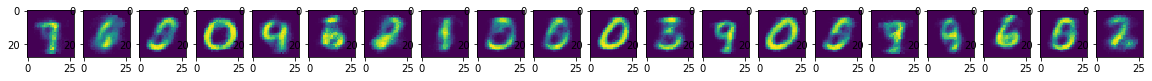


mean epoch 54 val loss: 661.570688520159

Saving validation results for epoch 54
validation prediction: val/val_epoch_54_pred
validation label: val/val_epoch_54_labels



mean epoch 55 train loss: 670.4946802717916



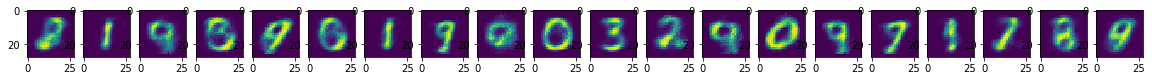


mean epoch 55 val loss: 657.7610626220703

Saving validation results for epoch 55
validation prediction: val/val_epoch_55_pred
validation label: val/val_epoch_55_labels



mean epoch 56 train loss: 668.0083421342829



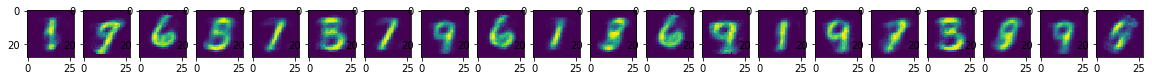


mean epoch 56 val loss: 656.880390712193

Saving validation results for epoch 56
validation prediction: val/val_epoch_56_pred
validation label: val/val_epoch_56_labels



mean epoch 57 train loss: 665.5461148722787



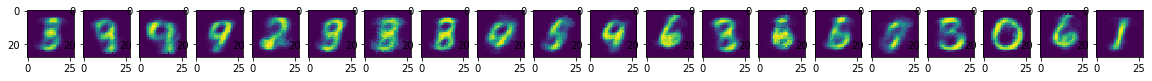


mean epoch 57 val loss: 655.1837670462472

Saving validation results for epoch 57
validation prediction: val/val_epoch_57_pred
validation label: val/val_epoch_57_labels



mean epoch 58 train loss: 663.1122359372257



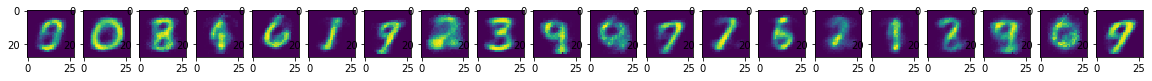


mean epoch 58 val loss: 653.5038408551898

Saving validation results for epoch 58
validation prediction: val/val_epoch_58_pred
validation label: val/val_epoch_58_labels



mean epoch 59 train loss: 661.0027874550123



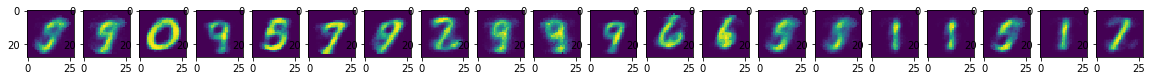


mean epoch 59 val loss: 651.5088768005371

Saving validation results for epoch 59
validation prediction: val/val_epoch_59_pred
validation label: val/val_epoch_59_labels



mean epoch 60 train loss: 658.6792445493548



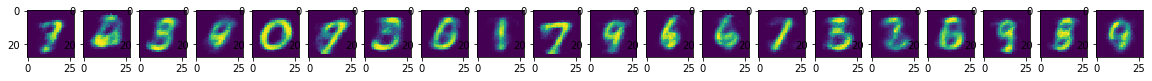


mean epoch 60 val loss: 648.8021087646484

Saving validation results for epoch 60
validation prediction: val/val_epoch_60_pred
validation label: val/val_epoch_60_labels



mean epoch 61 train loss: 656.8985774693864



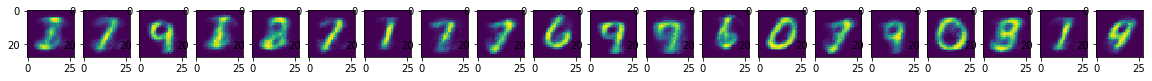


mean epoch 61 val loss: 646.9949373517718

Saving validation results for epoch 61
validation prediction: val/val_epoch_61_pred
validation label: val/val_epoch_61_labels



mean epoch 62 train loss: 653.9186177457317



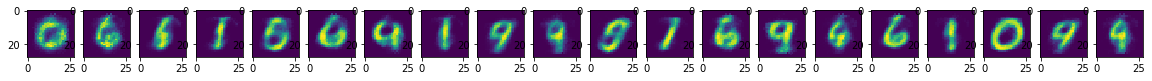


mean epoch 62 val loss: 643.6763670785086

Saving validation results for epoch 62
validation prediction: val/val_epoch_62_pred
validation label: val/val_epoch_62_labels



mean epoch 63 train loss: 651.9359682918935



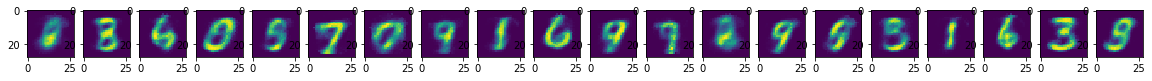


mean epoch 63 val loss: 642.9736796787807

Saving validation results for epoch 63
validation prediction: val/val_epoch_63_pred
validation label: val/val_epoch_63_labels



mean epoch 64 train loss: 649.7169234715151



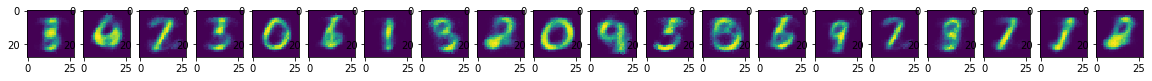


mean epoch 64 val loss: 639.672231401716

Saving validation results for epoch 64
validation prediction: val/val_epoch_64_pred
validation label: val/val_epoch_64_labels



mean epoch 65 train loss: 647.4608189272077



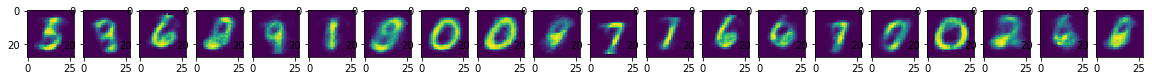


mean epoch 65 val loss: 639.114917755127

Saving validation results for epoch 65
validation prediction: val/val_epoch_65_pred
validation label: val/val_epoch_65_labels



mean epoch 66 train loss: 645.7112270055193



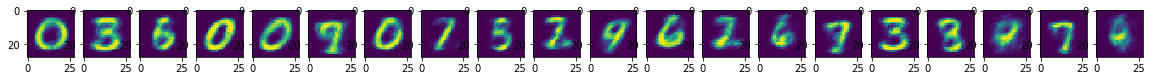


mean epoch 66 val loss: 635.7499171665737

Saving validation results for epoch 66
validation prediction: val/val_epoch_66_pred
validation label: val/val_epoch_66_labels



mean epoch 67 train loss: 642.9485414655021



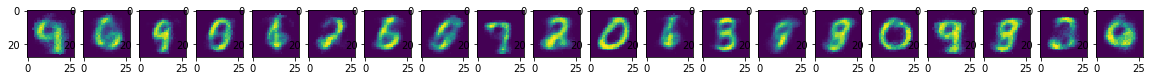


mean epoch 67 val loss: 632.3854969569614

Saving validation results for epoch 67
validation prediction: val/val_epoch_67_pred
validation label: val/val_epoch_67_labels



mean epoch 68 train loss: 640.5809784278441



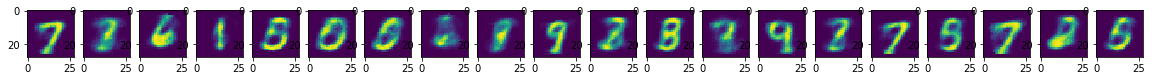


mean epoch 68 val loss: 629.1397023882184

Saving validation results for epoch 68
validation prediction: val/val_epoch_68_pred
validation label: val/val_epoch_68_labels



mean epoch 69 train loss: 638.471586008822



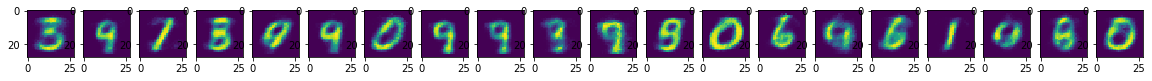


mean epoch 69 val loss: 627.9102690560477

Saving validation results for epoch 69
validation prediction: val/val_epoch_69_pred
validation label: val/val_epoch_69_labels



mean epoch 70 train loss: 636.1346590877919



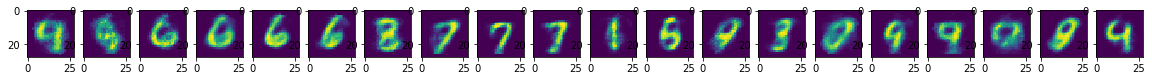


mean epoch 70 val loss: 627.3319326128278

Saving validation results for epoch 70
validation prediction: val/val_epoch_70_pred
validation label: val/val_epoch_70_labels



mean epoch 71 train loss: 633.9015699065134



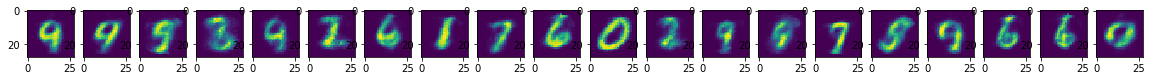


mean epoch 71 val loss: 625.5117514474051

Saving validation results for epoch 71
validation prediction: val/val_epoch_71_pred
validation label: val/val_epoch_71_labels



mean epoch 72 train loss: 630.6779011587079



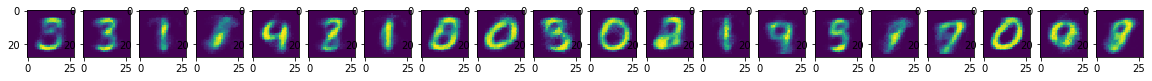


mean epoch 72 val loss: 624.011668069022

Saving validation results for epoch 72
validation prediction: val/val_epoch_72_pred
validation label: val/val_epoch_72_labels



mean epoch 73 train loss: 629.2191034552757



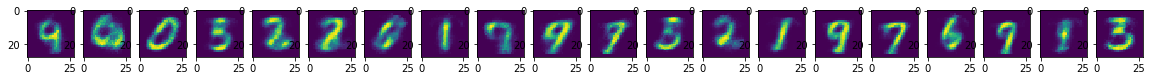


mean epoch 73 val loss: 622.2956493922642

Saving validation results for epoch 73
validation prediction: val/val_epoch_73_pred
validation label: val/val_epoch_73_labels



mean epoch 74 train loss: 627.8413668857531



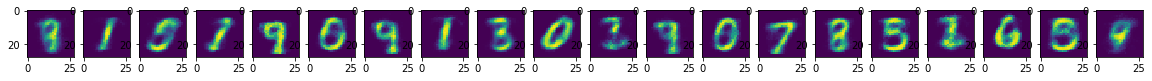


mean epoch 74 val loss: 619.2778374808175

Saving validation results for epoch 74
validation prediction: val/val_epoch_74_pred
validation label: val/val_epoch_74_labels


In [ ]:
val_dir = "val/"
try:
    os.makedirs(val_dir)
except FileExistsError:
    pass
train_state_dir = "net_states/"
try:
    os.makedirs(train_state_dir)
except FileExistsError:
    pass

epoch = 0
val_i = 0
train_start_time = time.time()
for epoch in tqdm(range(epochs)):
    
    batch_nr = 0
    epoch_loss = np.zeros(len(train_loader))
    
    """Actual training step"""
    for train_mini_batch in tqdm(train_loader):
        
        batch_loss, train_output = utils.vstep(net, train_mini_batch[0], train_mini_batch[0], loss_func, gamma, optimizer, device, mode="train", log_file=log_file)
        epoch_loss[batch_nr] = batch_loss.item()
        batch_nr += 1
    
    mean_epoch_loss = epoch_loss.mean()
    train_loss[epoch] = mean_epoch_loss
    print(f"mean epoch {epoch} train loss: {mean_epoch_loss}\n")
    
    
    """save the neural networks state"""
    if epoch in save_state_epochs:
        train_state_epoch_file_path = train_state_dir + f"state_epoch_{epoch}"
        #train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
        #torch.save(train_state, train_state_epoch_file_path)
        torch.save(net.state_dict(), train_state_epoch_file_path)
        net_state_paths.append(train_state_epoch_file_path)
        print(f"saved model from epoch {epoch}")
        
    """
    Validation
    """
    #val_epochs = [100000]
    if epoch in val_epochs:
        val_label = []
        val_pred = []
        
        val_batch_nr = 0
        val_epoch_loss = np.zeros(len(val_loader))
        
        for val_mini_batch in tqdm(val_loader):
            label_batch = val_mini_batch[1]
            val_label.append(label_batch.detach().cpu().numpy())
            val_batch_loss, val_output = utils.vstep(net, val_mini_batch[0], val_mini_batch[0], loss_func, gamma, optimizer, device, mode="val", log_file=log_file)
            val_epoch_loss[val_batch_nr] = val_batch_loss.item()
            val_pred.append(val_output.detach().cpu().numpy())
            
            if val_batch_nr == 0:
                num_images = batch_size
                fig, ax = plt.subplots(1,num_images)
                for i in range(num_images):
                    ax[i].imshow(val_pred[-1].reshape((batch_size,1,28,28))[i,0])
                plt.show()
                #ax[1].imshow(val_label[0].reshape((batch_size,1,28,28))[0,0])

            val_batch_nr += 1
            
        mean_val_epoch_loss = val_epoch_loss.mean()
        val_loss[val_i] = mean_val_epoch_loss
        print(f"mean epoch {epoch} val loss: {mean_val_epoch_loss}\n")
        
        val_i += 1
        
        print(f"Saving validation results for epoch {epoch}")
        
        val_pred_path = val_dir + f"val_epoch_{epoch}_pred"
        val_label_path = val_dir + f"val_epoch_{epoch}_labels"
        #print(np.array(functools.reduce(operator.iconcat, val_pred, [])))
        np.array(functools.reduce(operator.iconcat, val_pred, [])).tofile(val_pred_path, sep=" ")
        np.array(functools.reduce(operator.iconcat, val_label, [])).tofile(val_label_path, sep=" ")
        #np.array(val_pred).tofile(val_pred_path)
        #np.array(val_label).tofile(val_pred_label)
        
        val_pred_paths.append(val_pred_path)
        val_label_paths.append(val_label_path)
        print(f"validation prediction: {val_pred_path}")
        print(f"validation label: {val_label_path}")
        
log_file.close()
train_end_time = time.time()

In [ ]:
print(f"training time: {train_end_time-train_start_time}s")

In [ ]:
"""Plot training loss curve and save as image"""
plt.rcParams['figure.figsize'] = [10, 10]
loss_img_file_name = "train_loss.png"
x_epochs = range(epochs)
fig, ax = plt.subplots()
ax.plot(x_epochs, train_loss, label="train loss")
ax.plot(val_epochs, val_loss, label="val loss")
leg = ax.legend()
#plt.title()
plt.xlabel("epoch")
#plt.ylabel("loss")
plt.savefig(loss_img_file_name)
plt.show()
plt.close()
train_loss_txt_file_name = "train_loss.txt"
np.savetxt(train_loss_txt_file_name, train_loss)
val_loss_txt_file_name = "val_loss.txt"
np.savetxt(val_loss_txt_file_name, val_loss)

In [ ]:
train_state_file_path = train_state_dir + f"state_epoch_{epoch}"
#train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(net.state_dict(), train_state_file_path)
net_state_paths.append(train_state_file_path)
print(f"saved model from epoch {epoch}")

In [ ]:
load_epoch = epoch
print(f"loading model from epoch {load_epoch}")
net_state_path = f"net_states/state_epoch_{load_epoch}"
net.load_state_dict(torch.load(net_state_path))
net.eval()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
test_image, test_label = dataset[0]
indices = np.arange(0,10)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)

val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)

test_images = []
outputs = []
#for test_batch in train_loader:
for test_batch in val_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    #plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(test_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(2,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(outputs[image_i].detach().cpu()[0,0])

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
num_samples = 10
#latent_samples = torch.randint(low=1, high=1000, size=(num_samples, latent_size//2) )
latent_samples = torch.randn(size=(num_samples, latent_size//2) )

output = net.decoder(latent_samples.to(device).float())
print(output.size())
print(len(output))
fig, ax = plt.subplots(1,num_samples)
for i in range(num_samples):
    ax[i].imshow(output.detach().cpu()[i][0])
    

In [ ]:
labels = np.array(dataset.label_df["number"], dtype=int)
sorted_label_indices = []
for class_num in range(0,10):
    sorted_label_indices.append(np.array(np.where(labels == class_num))[0])
    print(np.array(np.where(labels == class_num)).shape)
    
#print(len(sorted_label_indices))
#print(sorted_label_indices[0].size)
#print(sorted_label_indices[0][0])

In [ ]:
latent_vectors = []

for class_num in range(0,10):
    num_per_class = 800
    #num_per_class = len(sorted_label_indices[class_num]
    
    class_latent_vectors = np.zeros( (num_per_class,2,latent_size//2) )

    
    #for image_i in range(len(sorted_label_indices[class_num])):
    for image_i in tqdm(range(num_per_class)):
        #print(image_i)
        #get one image
        image_index = sorted_label_indices[class_num][image_i]
        #print(image_index)
        image = dataset.get_image(image_index)[0]
        if image_i < 3:
            plt.imshow(image.detach().cpu()[0])
            plt.show()
        
        #print(image.shape)
        
        #compress to latent space
        #net.encoder(image.float())
        net(image.float())
        
        #save latent variables
        latent_mu, log_latent_sigma = net.get_latent_variables()
        #print(latent_mu.size())
        class_latent_vectors[image_i][0] = latent_mu.detach().cpu()[0]
        class_latent_vectors[image_i][1] = log_latent_sigma.detach().cpu()[0]
        
    
    latent_vectors.append(class_latent_vectors)
    

In [ ]:
latent_vectors = np.array(latent_vectors)
#log_var is saved as a latent variable
latent_vectors[:,:,1,:] = np.exp(latent_vectors[:,:,1,:])
print(latent_vectors.shape)

In [ ]:
mean_latent_vectors = latent_vectors.mean(axis=1)
std_latent_vector = latent_vectors.std(axis=1)
#cov_mu_latent_vector = np.cov(zero_latent_vectors[:,0])
#cov_sigma_latent_vector = np.cov(zero_latent_vectors[:,1])


print("mean latent vectors")
for i in range(0,10):
    print(f"number {i}")
    print("mu")
    print(mean_latent_vectors[i][0])
    print("sigma")
    print(mean_latent_vectors[i][1])
    #print("std latent vector")
    #print(std_latent_vector[i])

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
#gen_num = 2

ex_per_num = 5

fig, ax = plt.subplots(10,ex_per_num)

for gen_num in range(0,10):

    latent_shape = mean_latent_vectors[gen_num][0].shape
    #print(latent_shape)
    ex_shape = np.concatenate(([ex_per_num], latent_shape))
    #print(ex_shape)
    
    latent_z_sample = net.dist.sample(ex_shape).to(device)
    #print(latent_z_sample.size())
    mu = torch.tensor(mean_latent_vectors[gen_num][0]).to(device).float()
    log_sigma = torch.tensor(mean_latent_vectors[gen_num][1]).to(device).float()
    
    latent_sample = torch.zeros(tuple(ex_shape)).to(device).float()
    for ex in range(0,ex_per_num):
        latent_sample[ex] = mu + torch.exp(0.5*log_sigma)*latent_z_sample[ex]
    
    #print(latent_sample.size())
        
    ex_sample_images = net.decoder(latent_sample)
    
    #print(ex_sample_images.size())
    
    for ex in range(ex_per_num):
        ax[gen_num, ex].imshow(ex_sample_images[ex,:,:].detach().cpu().numpy()[0])

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

In [ ]:
start = 2

interact_kwargs = {}
for i in range(0,latent_size//2):
    key = f"x{i}"
    #print(mean_latent_vectors.shape)
    mu = mean_latent_vectors[start][0][i]
    sigma = np.exp(mean_latent_vectors[start][1][i])
    #delta = 2*sigma
    delta = 6.
    low = mu - delta
    high = mu + delta
    interact_kwargs[key] = (low,high)

#interact_kwargs

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
latent_vector = torch.zeros((latent_size//2)).to(device)

#@interact(x0=(-5.,5.), x1=(-5.,5.), x2=(-5.,5.), x3=(-5.,5.), x4=(-5.,5.), x5=(-5.,5.), x6=(-5.,5.), x7=(-5.,5.), x8=(-5.,5.), x9=(-5.,5.))
@interact(**interact_kwargs)
#def update_latent_vector(x0, x1, x2, x3, x4):
def update_latent_vector(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9):
    
    latent_vector[0] = x0
    latent_vector[1] = x1
    latent_vector[2] = x2
    latent_vector[3] = x3
    latent_vector[4] = x4
    latent_vector[5] = x5
    latent_vector[6] = x6
    latent_vector[7] = x7
    latent_vector[8] = x8
    latent_vector[9] = x9
    print(latent_vector)
    image = net.decoder(latent_vector).detach().cpu().numpy()[0][0]
    plt.imshow(image)

In [ ]:
for i in range(0,10):
    print(f"number {i}")
    print("mu")
    print(mean_latent_vectors[i][0])

In [ ]:
"""Denoising images"""

plt.rcParams['figure.figsize'] = [20, 5]
test_image, test_label = dataset[0]
indices = np.arange(15,30)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
noise_scale = 0.3
noise_func = torch.randn
noise_kwargs = {}

"""
dataset.transform = torchvision.transforms.Compose([
                #torchvision.transforms.ToTensor(),
                dataset_class_gsimage.min_max_scaler(device=device),
                dataset_class_gsimage.add_normal_noise(0.,0.1,device=device),
            ])
"""

dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.min_max_scaler(device=device),
            ])

#dataset.transform = None

val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)
test_images = []
noisy_images = []
outputs = []
for test_batch in val_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    noise_kwargs["size"] = test_image.size()
    noise = noise_scale * noise_func(**noise_kwargs).to(device)
    noisy_image = test_image + noise
    noisy_images.append(noisy_image)
    #plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(noisy_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(3,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(noisy_images[image_i].detach().cpu()[0,0])
    ax[2, image_i].imshow(outputs[image_i].detach().cpu()[0,0])
    
    